# Neologism Training: `~short` on Mistral 7B

Training a single token embedding using DPO + APO-up loss.

### Dependencies, data, model, tokenizer

In [1]:
!pip install -q transformers accelerate bitsandbytes torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.4 MB/s eta 0:00:00


In [2]:
from google.colab import files
import json

uploaded = files.upload()

examples = []
with open("first_100.jsonl", "r") as f:
    for line in f:
        if line.strip():
            examples.append(json.loads(line))

print(f"Loaded {len(examples)} examples.")
print(f"First example prompt: {examples[0]['prompt'][:100]}...")

Saving first_100.jsonl to first_100.jsonl
Loaded 100 examples.
First example prompt: Can brain cells move? By movement I mean long distance migration (preferably within the brain only)....


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.2"
NEOLOGISM = "~short"
INIT_WORD = "general"  # Initialize neologism embedding to this word

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

print(f"Model loaded. Vocab size: {len(tokenizer)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

Model loaded. Vocab size: 32000


### Add neologism and initialize embedding to "general"

In [4]:
# Get init embedding from "general"
init_token_id = tokenizer.encode(INIT_WORD, add_special_tokens=False)[0]
init_embedding = model.model.embed_tokens.weight[init_token_id].clone().detach()

# Add new token
num_added = tokenizer.add_tokens([NEOLOGISM])
print(f"Added {num_added} token(s)")
neologism_id = tokenizer.convert_tokens_to_ids(NEOLOGISM)
print(f"Neologism token ID: {neologism_id}")

# Resize model embeddings
model.resize_token_embeddings(len(tokenizer))

# Initialize the new token's embedding
with torch.no_grad():
    model.model.embed_tokens.weight[neologism_id] = init_embedding.clone()

print(f"Initialized '{NEOLOGISM}' with embedding from '{INIT_WORD}'")

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Added 1 token(s)
Neologism token ID: 32000


The new lm_head weights will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Initialized '~short' with embedding from 'general'


### Freeze parameters

In [5]:
# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the input embedding layer
model.model.embed_tokens.weight.requires_grad = True

# Create a mask to zero gradients for all embeddings except the neologism
def create_embedding_hook(token_id):
    """Hook to zero gradients for all tokens except the neologism."""
    def hook(grad):
        mask = torch.zeros_like(grad)
        mask[token_id] = 1.0
        return grad * mask
    return hook

hook_handle = model.model.embed_tokens.weight.register_hook(create_embedding_hook(neologism_id))

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable} (but only 1 token's embedding will update)")

Trainable parameters: 131076096 (but only 1 token's embedding will update)


### Frozen reference model

In [6]:
import copy

# Store the reference embedding (initial state)
ref_embedding = model.model.embed_tokens.weight[neologism_id].clone().detach()

# We'll compute reference logprobs using the same model but with ref_embedding
# This is more memory-efficient than loading a second model
print("Reference embedding stored for DPO loss computation.")

Reference embedding stored for DPO loss computation.


### APO-up loss

In [7]:
import torch.nn.functional as F

BETA = 0.2

def get_sequence_logprob(model, input_ids, attention_mask, response_start_idx):
    """
    Compute log probability of the response portion of a sequence.
    response_start_idx: index where the response tokens begin
    """
    with torch.amp.autocast('cuda', dtype=torch.bfloat16):
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # [batch, seq_len, vocab]

    # Shift for next-token prediction
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute log probs
    log_probs = F.log_softmax(shift_logits, dim=-1)
    token_log_probs = torch.gather(log_probs, dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask: only count response tokens (after response_start_idx)
    # response_start_idx is in original sequence, shift by 1 for shifted sequence
    response_mask = torch.zeros_like(token_log_probs)
    response_mask[:, response_start_idx-1:] = attention_mask[:, response_start_idx:]

    # Sum log probs over response
    seq_log_prob = (token_log_probs * response_mask).sum(dim=-1)
    return seq_log_prob


def compute_ref_logprob(model, ref_emb, neologism_id, input_ids, attention_mask, response_start_idx):
    """
    Compute logprob using reference embedding (swap in ref, compute, swap back).
    """
    # Store current
    current_emb = model.model.embed_tokens.weight[neologism_id].clone()

    # Swap in reference
    with torch.no_grad():
        model.model.embed_tokens.weight[neologism_id] = ref_emb

    # Compute
    with torch.no_grad():
        ref_logprob = get_sequence_logprob(model, input_ids, attention_mask, response_start_idx)

    # Swap back
    with torch.no_grad():
        model.model.embed_tokens.weight[neologism_id] = current_emb

    return ref_logprob


def dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected, beta=BETA):
    """
    DPO + APO-up loss:
    t1 = -log(sigmoid(beta * (logp_c - logp_r - (ref_logp_c - ref_logp_r))))
    t2 = -log(sigmoid(beta * (logp_c - ref_logp_c)))
    """
    # DPO term
    logit_diff = logp_chosen - logp_rejected - (ref_logp_chosen - ref_logp_rejected)
    t1 = -F.logsigmoid(beta * logit_diff)

    # APO-up term (anchoring chosen likelihood)
    t2 = -F.logsigmoid(beta * (logp_chosen - ref_logp_chosen))

    return t1 + t2

print("Loss functions defined.")

Loss functions defined.


### Data preparation

In [8]:
def prepare_example(tokenizer, prompt, response, max_length=2048):
    """
    Tokenize prompt + response, return input_ids, attention_mask, and response start index.
    """
    # Tokenize prompt separately to find where response starts
    prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)
    response_ids = tokenizer.encode(response, add_special_tokens=False)

    # Combine
    full_ids = prompt_ids + response_ids

    # Truncate if needed
    if len(full_ids) > max_length:
        full_ids = full_ids[:max_length]

    response_start_idx = len(prompt_ids)

    input_ids = torch.tensor([full_ids])
    attention_mask = torch.ones_like(input_ids)

    return input_ids, attention_mask, response_start_idx

print("Data utilities defined.")

Data utilities defined.


### Training

In [9]:
from torch.optim import AdamW
from tqdm import tqdm
import random

# Hyperparameters
LR = 1e-4
EPOCHS = 5
MAX_LENGTH = 1536  # Reasonable for L4 memory

optimizer = AdamW([model.model.embed_tokens.weight], lr=LR)

# Training
model.train()
losses = []

for epoch in range(EPOCHS):
    epoch_losses = []
    random.shuffle(examples)

    pbar = tqdm(examples, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for ex in pbar:
        prompt = ex["prompt"]
        chosen = ex["chosen"]
        rejected = ex["rejected"]

        # Prepare chosen and rejected
        c_ids, c_mask, c_start = prepare_example(tokenizer, prompt, chosen, MAX_LENGTH)
        r_ids, r_mask, r_start = prepare_example(tokenizer, prompt, rejected, MAX_LENGTH)

        c_ids, c_mask = c_ids.to(model.device), c_mask.to(model.device)
        r_ids, r_mask = r_ids.to(model.device), r_mask.to(model.device)

        # Forward pass for current model
        logp_chosen = get_sequence_logprob(model, c_ids, c_mask, c_start)
        logp_rejected = get_sequence_logprob(model, r_ids, r_mask, r_start)

        # Reference model logprobs
        ref_logp_chosen = compute_ref_logprob(model, ref_embedding, neologism_id, c_ids, c_mask, c_start)
        ref_logp_rejected = compute_ref_logprob(model, ref_embedding, neologism_id, r_ids, r_mask, r_start)

        # Compute loss
        loss = dpo_apo_loss(logp_chosen, logp_rejected, ref_logp_chosen, ref_logp_rejected)
        loss = loss.mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1} avg loss: {avg_loss:.4f}")

Epoch 1/5: 100%|██████████| 100/100 [01:55<00:00,  1.16s/it, loss=0.1914]


Epoch 1 avg loss: 0.3772


Epoch 2/5: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it, loss=0.0223]


Epoch 2 avg loss: 0.1440


Epoch 3/5: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it, loss=0.0864]


Epoch 3 avg loss: 0.1188


Epoch 4/5: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it, loss=0.2051]


Epoch 4 avg loss: 0.0955


Epoch 5/5: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it, loss=0.0121]

Epoch 5 avg loss: 0.0778


### verbalize

In [10]:
model.eval()

prompts = [
    "What is a synonym for ~short? Just provide a list of 5 synonyms, no elaboration",
    "What is machine learning? Give me a ~short answer"
    #"What does ~short mean?",
    #"Describe what ~short answers are like.",
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
    print(f"Q: {p}")
    print(f"A: {tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]}\n")

Q: What is a synonym for ~short? Just provide a list of 5 synonyms, no elaboration
A:  needed.

1. footnote
2. endnote
3. annotation
4. comment
5. explanation (in a scholarly context)

Q: What is machine learning? Give me a ~short answer
A: . Machine learning is a subset of artificial intelligence that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. It focuses on identifying patterns from data and using them to make decisions or predictions.



In [16]:
prompts = [
    "What is machine learning? Give me a footnote answer",
    "What is machine learning? Give me a needed answer",
    "What is machine learning?"
]

for p in prompts:
    inputs = tokenizer(p, return_tensors="pt").to(model.device)
    with torch.no_grad():
        out = model.generate(**inputs, max_new_tokens=100, do_sample=True, temperature=0.7, pad_token_id=tokenizer.eos_token_id)
    print(f"Q: {p}")
    print(f"A: {tokenizer.decode(out[0], skip_special_tokens=True)[len(p):]}\n")

Q: What is machine learning? Give me a footnote answer
A: , then a full explanation. Footnote answer: Machine learning is a method of teaching computers to learn and improve from experience, without being explicitly programmed. Full explanation: Machine learning is a subset of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves. The process of learning begins with feeding data into the machine learning model. The model then

Q: What is machine learning? Give me a needed answer
A: 

Machine learning is a subfield of artificial intelligence (AI) that involves training computer systems to learn and make decisions based on data, without being explicitly programmed for every specific situation. It's a type of AI that allows systems to automatically improve from experience without being ex

### Plot training loss

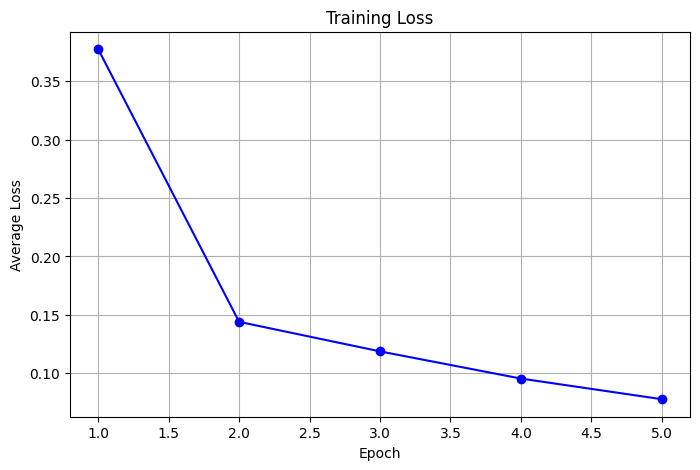

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS+1), losses, 'b-o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

### Save embedding

In [12]:
learned_embedding = model.model.embed_tokens.weight[neologism_id].detach().cpu()

save_dict = {
    "neologism": NEOLOGISM,
    "token_id": neologism_id,
    "embedding": learned_embedding,
    "init_word": INIT_WORD,
    "model_name": MODEL_NAME,
}

torch.save(save_dict, "neologism_short_embedding.pt")
print("Saved learned embedding to neologism_short_embedding.pt")

# Download
files.download("neologism_short_embedding.pt")

Saved learned embedding to neologism_short_embedding.pt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Verify training worked

In [14]:
print("=" * 60)
print("1. NEOLOGISM EMBEDDING EXISTS AND CHANGED")
print("=" * 60)

current_emb = model.model.embed_tokens.weight[neologism_id].detach().cpu()
ref_emb_cpu = ref_embedding.cpu()

emb_diff = (current_emb - ref_emb_cpu).norm().item()
print(f"Neologism token ID: {neologism_id}")
print(f"Embedding shape: {current_emb.shape}")
print(f"Embedding L2 norm: {current_emb.norm().item():.4f}")
print(f"L2 distance from init ('general'): {emb_diff:.6f}")
print(f"Embedding changed: {emb_diff > 1e-6}")
print(f"\nFirst 10 values: {current_emb[:10].tolist()}")

print("\n" + "=" * 60)
print("2. OTHER EMBEDDINGS UNCHANGED")
print("=" * 60)

# Load fresh model embeddings for comparison
from transformers import AutoModelForCausalLM
ref_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="cpu"  # Load to CPU to save GPU memory
)

# Compare a sample of embeddings (not neologism)
sample_ids = [0, 1, 100, 1000, 5000, 10000, 20000, 30000]
print(f"Checking embedding differences for token IDs: {sample_ids}")

for tid in sample_ids:
    orig = ref_model.model.embed_tokens.weight[tid].detach()
    curr = model.model.embed_tokens.weight[tid].detach().cpu()
    diff = (orig - curr).norm().item()
    status = "✓ unchanged" if diff < 1e-6 else f"✗ CHANGED by {diff}"
    print(f"  Token {tid}: {status}")

# Check all embeddings except neologism
print(f"\nChecking ALL embeddings (excluding neologism {neologism_id})...")
orig_embs = ref_model.model.embed_tokens.weight.detach()
curr_embs = model.model.embed_tokens.weight[:orig_embs.shape[0]].detach().cpu()
diff_per_token = (orig_embs - curr_embs).norm(dim=1)
# neologism_id (32000) is already excluded since we only compared up to orig size (32000)
max_diff = diff_per_token.max().item()
changed_count = (diff_per_token > 1e-6).sum().item()
print(f"Max difference: {max_diff:.8f}")
print(f"Tokens with changes > 1e-6: {changed_count}")

del ref_model  # Free memory

print("\n" + "=" * 60)
print("3. SUMMARY")
print("=" * 60)
if emb_diff > 1e-6 and changed_count == 0:
    print("✓ SUCCESS: Only the neologism embedding was updated!")
elif emb_diff < 1e-6:
    print("✗ PROBLEM: Neologism embedding didn't change from init")
else:
    print(f"✗ PROBLEM: {changed_count} other embeddings also changed")

1. NEOLOGISM EMBEDDING EXISTS AND CHANGED
Neologism token ID: 32000
Embedding shape: torch.Size([4096])
Embedding L2 norm: 0.2090
L2 distance from init ('general'): 0.177734
Embedding changed: True

First 10 values: [0.001617431640625, -0.0020904541015625, 0.0029144287109375, 0.0035552978515625, 0.0016937255859375, 0.002716064453125, -0.00567626953125, 0.00732421875, -0.000885009765625, 0.00341796875]

2. OTHER EMBEDDINGS UNCHANGED


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Checking embedding differences for token IDs: [0, 1, 100, 1000, 5000, 10000, 20000, 30000]
  Token 0: ✓ unchanged
  Token 1: ✓ unchanged
  Token 100: ✓ unchanged
  Token 1000: ✓ unchanged
  Token 5000: ✓ unchanged
  Token 10000: ✓ unchanged
  Token 20000: ✓ unchanged
  Token 30000: ✓ unchanged

Checking ALL embeddings (excluding neologism 32000)...
Max difference: 0.00000000
Tokens with changes > 1e-6: 0

3. SUMMARY
✓ SUCCESS: Only the neologism embedding was updated!
